This notebook analyzes a sample of the dataset to get a rough idea about the range of ratings, genres, and movie titles.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import re

### Load datasets

In [2]:
def load_movies_dataset(sample_size = 40000, random_sample=True):
    
    '''
    Note: this function opens the whole csv to get the total number of rows 
    --> for large csv files opening via shell to get the number of rows is much faster and does not require to load the file into memory
    
    Note: By sampling the movies dataset not all user ratings might match with the given movieIDs      
    '''
    
    path = '/media/vincent/harddrive/Movielens_data/ml-25m/'
    
    if random_sample == True:
        random.seed(30) 

        n_rows = sum(1 for line in open(path + 'movies.csv')) - 1 #number of records in file (excludes header)
        skip = sorted(random.sample(range(1,n_rows+1),n_rows-sample_size)) #the 0-indexed header will not be included in the skip list

        movie_data = pd.read_csv(
            path + 'movies.csv',
            encoding = "ISO-8859-1", 
            skiprows = skip,
            header=0
        )
        
    else:
        movie_data = pd.read_csv(
            path + 'movies.csv',
            encoding = "ISO-8859-1", 
            nrows = sample_size,
            header=0
        )
    
    movie_data['movie_title'] = movie_data['title']
    
    return movie_data[['movieId','movie_title','genres']]


def load_ratings(sample_size = 20000, random_sample=True):
    
    '''
    Note: this function opens the whole csv to get the total number of rows 
    --> for large csv files opening via shell to get the number of rows is much faster and does not require to load the file into memory
    '''
        
    path = '/media/vincent/harddrive/Movielens_data/ml-25m/'
    
    if random_sample == True:
        random.seed(30)

        n_rows = sum(1 for line in open(path + 'ratings.csv')) - 1 #number of records in file (excludes header)
        skip = sorted(random.sample(range(1,n_rows+1),n_rows-sample_size)) #the 0-indexed header will not be included in the skip list


        ratings_data = pd.read_csv(
            path + 'ratings.csv',
            encoding = "ISO-8859-1",
            skiprows = skip,
            header=0
        )

    else:    
        ratings_data = pd.read_csv(
            path + 'ratings.csv',
            encoding = "ISO-8859-1",
            nrows = sample_size,
            header=0
        )

    return ratings_data


def load_ratings_with_titles():
    ratings_data = load_ratings()
    movies_data = load_movies_dataset()
    ratings_data['userId'] = ratings_data['userId'].map(lambda k: f"User_{k}")
        
    ratings_and_movies = pd.merge(ratings_data , movies_data[['movie_title','movieId']], on='movieId', how='left')
        
    return ratings_and_movies[['userId', 'movie_title', 'rating']], ratings_data, movies_data

In [3]:
#load data
movie_ratings_df, ratings_data, movies_data = load_ratings_with_titles()

In [4]:
ratings_data.head()

,userId,movieId,rating,timestamp
0,User_3,87430,3.0,1484755925
1,User_13,78266,1.0,1297907375
2,User_43,4246,3.5,1170494217
3,User_52,3617,2.5,1298355356
4,User_59,1754,3.5,1111567463


In [5]:
movies_data.head()

,movieId,movie_title,genres
0,3,Grumpier Old Men (1995),Comedy|Romance
1,5,Father of the Bride Part II (1995),Comedy
2,7,Sabrina (1995),Comedy|Romance
3,10,GoldenEye (1995),Action|Adventure|Thriller
4,11,"American President, The (1995)",Comedy|Drama|Romance


In [6]:
movie_ratings_df.head()

,userId,movie_title,rating
0,User_3,Green Lantern (2011),3.0
1,User_13,Splice (2009),1.0
2,User_43,NaN,3.5
3,User_52,NaN,2.5
4,User_59,Fallen (1998),3.5


### check for missings

By sampling the movies dataset not all user ratings might match with the given movieIDs

In [7]:
movie_ratings_df[movie_ratings_df['movie_title'].isna()].head()

,userId,movie_title,rating
2,User_43,NaN,3.5
3,User_52,NaN,2.5
5,User_59,NaN,3.5
7,User_75,NaN,3.0
10,User_127,NaN,3.5


In [8]:
movie_ratings_df[movie_ratings_df['movie_title'].isna()].shape

(7746, 3)

In [9]:
#drop NAs
movie_ratings_df.dropna(inplace=True)
movie_ratings_df.shape

(12254, 3)

### analyze genres

#### get unique genres

In [10]:
genre_help_df = movies_data['genres'].str.split('|', expand = True)
genre_help_df.head()

,0,1,2,3,4,5,6,7,8,9
0,Comedy,Romance,None,None,None,None,None,None,None,None
1,Comedy,None,None,None,None,None,None,None,None,None
2,Comedy,Romance,None,None,None,None,None,None,None,None
3,Action,Adventure,Thriller,None,None,None,None,None,None,None
4,Comedy,Drama,Romance,None,None,None,None,None,None,None


In [11]:
genre_help_df[genre_help_df[genre_help_df.shape[1]-1].notnull()]

,0,1,2,3,4,5,6,7,8,9
9824,Action,Adventure,Comedy,Crime,Drama,Film-Noir,Horror,Mystery,Thriller,Western


In [12]:
#get all unique genres:
for i in range(genre_help_df.shape[1]):
    if i < 1:
        set_init = set(genre_help_df[i].unique())
        continue
    else:
        set_help = set(genre_help_df[i].unique())
        
    set_all = set_init.union(set_help)
    
    set_init = set_all
 

#list of unique genres:
uniq_genres = list(set_all)
print(uniq_genres)

#delete "None" entry:
del_idx = uniq_genres.index(None)
del uniq_genres[del_idx]


['(no genres listed)', 'Fantasy', 'Crime', 'Thriller', 'Film-Noir', 'Romance', 'Comedy', 'Sci-Fi', 'Animation', 'Drama', 'Children', 'Documentary', 'Musical', 'IMAX', 'Action', 'Adventure', 'Mystery', None, 'War', 'Horror', 'Western']


#### add genre columns

In [13]:
#create new column for each genre:
for genre in uniq_genres:
    
    movies_data[genre] = movies_data['genres'].str.contains(genre).replace(False, 0)

movies_data.head()

/home/vincent/anaconda3/envs/datascience/lib/python3.6/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,movieId,movie_title,genres,(no genres listed),Fantasy,Crime,Thriller,Film-Noir,Romance,Comedy,...,Children,Documentary,Musical,IMAX,Action,Adventure,Mystery,War,Horror,Western
0,3,Grumpier Old Men (1995),Comedy|Romance,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,Father of the Bride Part II (1995),Comedy,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,Sabrina (1995),Comedy|Romance,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,GoldenEye (1995),Action|Adventure|Thriller,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,11,"American President, The (1995)",Comedy|Drama|Romance,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### plot genre counts

In [14]:
sum_genres = movies_data.iloc[:,3:].sum(axis = 0, skipna = True) 
sum_genres.sort_values()

IMAX                    116.0
Film-Noir               233.0
Musical                 676.0
Western                 885.0
War                    1178.0
Fantasy                1703.0
Mystery                1868.0
Children               1879.0
Animation              1887.0
Sci-Fi                 2304.0
Adventure              2622.0
(no genres listed)     3234.0
Crime                  3394.0
Documentary            3559.0
Horror                 3808.0
Action                 4736.0
Romance                4998.0
Thriller               5571.0
Comedy                10734.0
Drama                 16464.0
dtype: float64

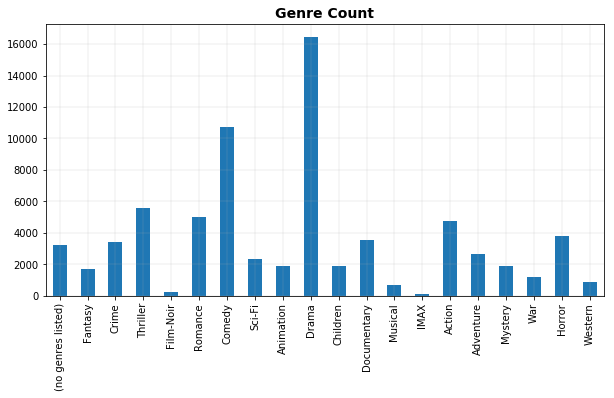

In [15]:
ax = sum_genres.plot.bar(figsize=(10,5))
ax.set_title('Genre Count', fontsize=14, fontweight='bold')
ax.grid(linewidth=0.2)

### analyze ratings

Dataset info: Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

In [16]:
rating_counts = ratings_data['rating'].value_counts()
rating_counts

4.0    5275
3.0    3928
5.0    3003
3.5    2484
4.5    1711
2.0    1351
2.5    1000
1.0     627
1.5     321
0.5     300
Name: rating, dtype: int64

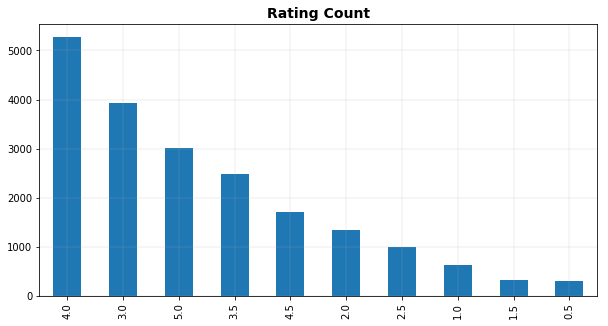

In [17]:
ax = rating_counts.plot.bar(figsize=(10,5))
ax.set_title('Rating Count', fontsize=14, fontweight='bold')
ax.grid(linewidth=0.2)

#### highest rated movies

In [18]:
movie_stats = movie_ratings_df.groupby('movie_title')['rating'].describe()
movie_stats.head()

,count,mean,std,min,25%,50%,75%,max
movie_title,,,,,,,,
$ellebrity (Sellebrity) (2012),1.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0
'night Mother (1986),1.0,4.0,NaN,4.0,4.0,4.0,4.0,4.0
*batteries not included (1987),1.0,4.0,NaN,4.0,4.0,4.0,4.0,4.0
...And Justice for All (1979),1.0,4.0,NaN,4.0,4.0,4.0,4.0,4.0
1-900 (06) (1994),1.0,5.0,NaN,5.0,5.0,5.0,5.0,5.0


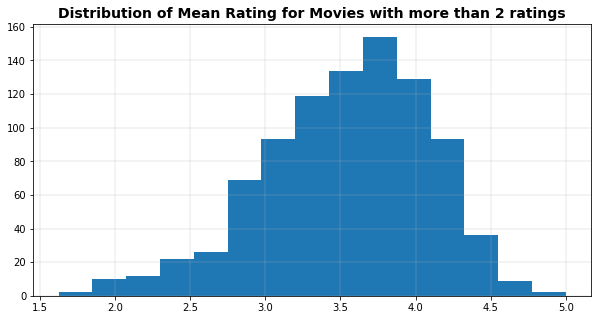

In [20]:
ax = movie_stats[movie_stats['count'] > 3]['mean'].hist(bins=15, figsize=(10,5))
ax.set_title('Distribution of Mean Rating for Movies with more than 2 ratings', fontsize=14, fontweight='bold')
ax.grid(linewidth=0.3)

In [21]:
#get best rated movies based on average rating:
best_movies = movie_stats[movie_stats['count'] > 5]['mean'].nlargest(3)
print('Best rated movies (based on mean rating): \n')
print(best_movies)

Best rated movies (based on mean rating): 

movie_title
Dark Knight Rises, The (2012)    4.708333
To Kill a Mockingbird (1962)     4.684211
Lawrence of Arabia (1962)        4.642857
Name: mean, dtype: float64


In [22]:
#get devation of ratings for best movies:
mask = ((movie_stats['count'] > 5) & (movie_stats['mean'] > 4.5))

movie_stats[mask]['std']

movie_title
Dark Knight Rises, The (2012)    0.396481
Lawrence of Arabia (1962)        0.377964
To Kill a Mockingbird (1962)     0.477567
Name: std, dtype: float64

In [23]:
movie_stats.filter(best_movies.index, axis=0)

,count,mean,std,min,25%,50%,75%,max
movie_title,,,,,,,,
"Dark Knight Rises, The (2012)",12.0,4.708333,0.396481,4.0,4.5,5.0,5.0,5.0
To Kill a Mockingbird (1962),19.0,4.684211,0.477567,3.5,4.5,5.0,5.0,5.0
Lawrence of Arabia (1962),7.0,4.642857,0.377964,4.0,4.5,4.5,5.0,5.0


In [24]:
#movies with biggest number of ratings:
movie_stats['count'].nlargest(5)

movie_title
Shawshank Redemption, The (1994)                         75.0
Star Wars: Episode IV - A New Hope (1977)                67.0
Star Wars: Episode V - The Empire Strikes Back (1980)    62.0
Matrix, The (1999)                                       54.0
Star Wars: Episode VI - Return of the Jedi (1983)        49.0
Name: count, dtype: float64

#### genre & ratings

In [25]:
#merge dfs to get ratings & genres
ratings_and_genre = pd.merge(ratings_data[['movieId','rating']], movies_data, on='movieId')
ratings_and_genre.head()

,movieId,rating,movie_title,genres,(no genres listed),Fantasy,Crime,Thriller,Film-Noir,Romance,...,Children,Documentary,Musical,IMAX,Action,Adventure,Mystery,War,Horror,Western
0,87430,3.0,Green Lantern (2011),Action|Adventure|Sci-Fi,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,87430,1.5,Green Lantern (2011),Action|Adventure|Sci-Fi,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,87430,1.0,Green Lantern (2011),Action|Adventure|Sci-Fi,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,87430,2.0,Green Lantern (2011),Action|Adventure|Sci-Fi,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,87430,3.5,Green Lantern (2011),Action|Adventure|Sci-Fi,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [26]:
#get most common genres:
most_common_genres = list(sum_genres.nlargest(10).index)

#create custom dict to store stats of genres:
genre_ratings_dict = {}
for genre in most_common_genres:
    mean_rating = ratings_and_genre[ratings_and_genre[genre] > 0]['rating'].mean()
    rating_count = ratings_and_genre[ratings_and_genre[genre] > 0]['rating'].count()
    genre_ratings_dict[genre] = [mean_rating,rating_count]
    
#create df:
genre_ratings_df = pd.DataFrame.from_dict(genre_ratings_dict)

#get final df:
genre_ratings_df = genre_ratings_df.transpose().reset_index() 

genre_ratings_df.columns = ['genre','mean_rating', 'rating_count']
genre_ratings_df.head()

,genre,mean_rating,rating_count
0,Drama,3.682685,5400.0
1,Comedy,3.425258,4161.0
2,Thriller,3.492128,3430.0
3,Romance,3.519819,2094.0
4,Action,3.489417,3685.0


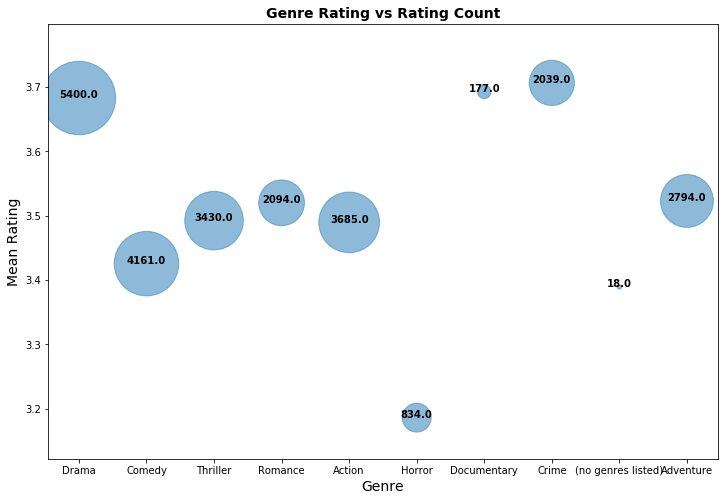

In [27]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter('genre', 'mean_rating', s='rating_count',alpha=0.5, data=genre_ratings_df)
ax.set_xlabel("Genre", size=14)
ax.set_ylabel("Mean Rating", size=14)
ax.set_title("Genre Rating vs Rating Count", size=14, fontweight = 'bold')
#For each point, we add a text inside the bubble
for line in range(0,genre_ratings_df.shape[0]):
     ax.text(genre_ratings_df.genre[line], genre_ratings_df.mean_rating[line], genre_ratings_df.rating_count[line], horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.show()

### analyze number of ratings per user

In [28]:
movie_ratings_df.groupby('userId')['movie_title'].unique()

userId
User_100015             [Wallace & Gromit: A Close Shave (1995)]
User_100023                                   [Sex Drive (2008)]
User_100036                             [Minority Report (2002)]
User_100047                              [Tropic Thunder (2008)]
User_100049                                  [Parenthood (1989)]
                                     ...                        
User_9998      [Gangs of New York (2002), X-Men Origins: Wolv...
User_99984                     [Star Wars: The Last Jedi (2017)]
User_99987                                 [Transformers (2007)]
User_99996                       [League of Their Own, A (1992)]
User_99999     [Rurouni Kenshin (RurÃ´ni Kenshin: Meiji kenka...
Name: movie_title, Length: 10846, dtype: object

In [29]:
movie_ratings_df.groupby('userId').size()

userId
User_100015    1
User_100023    1
User_100036    1
User_100047    1
User_100049    1
              ..
User_9998      2
User_99984     1
User_99987     1
User_99996     1
User_99999     1
Length: 10846, dtype: int64

In [30]:
movie_ratings_df.groupby('userId').size().describe()

count    10846.000000
mean         1.129817
std          0.454598
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         18.000000
dtype: float64

### analyze most recent ratings & ratings over time

In [31]:
#merge dfs to get ratings & genres
ratings_and_movies_time = pd.merge(ratings_data[['movieId','rating','timestamp']], movies_data, on='movieId')
ratings_and_movies_time.sort_values('timestamp', inplace=True)
ratings_and_movies_time.tail(10)

,movieId,rating,timestamp,movie_title,genres,(no genres listed),Fantasy,Crime,Thriller,Film-Noir,...,Children,Documentary,Musical,IMAX,Action,Adventure,Mystery,War,Horror,Western
6968,6754,4.0,1573622121,Underworld (2003),Action|Fantasy|Horror,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2587,1221,5.0,1573665542,"Godfather: Part II, The (1974)",Crime|Drama,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11364,162656,3.0,1573832225,Dishoom (2016),Action|Comedy,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
724,33794,4.5,1573877569,Batman Begins (2005),Action|Crime|IMAX,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3370,4855,3.0,1573933716,Dirty Harry (1971),Action|Crime|Thriller,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3790,47610,3.0,1573938844,"Illusionist, The (2006)",Drama|Fantasy|Mystery|Romance,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5715,48,3.0,1574014752,Pocahontas (1995),Animation|Children|Drama|Musical|Romance,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11107,168612,1.5,1574038093,Ghost in the Shell (2017),Action|Drama|Sci-Fi,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9799,203401,0.5,1574042235,Fred 2: Night of the Living Fred (2011),Adventure|Children|Comedy|Horror,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6830,1732,4.5,1574112354,"Big Lebowski, The (1998)",Comedy|Crime,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#calculate cumsum for each genre
for genre in uniq_genres:
    ratings_and_movies_time[genre + '_cumsum'] = ratings_and_movies_time[genre].cumsum()

#get cumsum labels:
col_labels = list(ratings_and_movies_time.columns)
cumsum_labels = [col for col in col_labels if 'cumsum' in col]
cumsum_labels.append('timestamp')

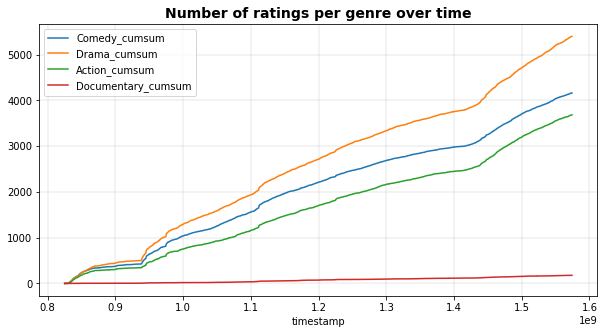

In [33]:
#plot genre counts over time:
ax = ratings_and_movies_time[cumsum_labels].plot.line(x='timestamp', y=['Comedy_cumsum', 'Drama_cumsum','Action_cumsum','Documentary_cumsum'], figsize=(10,5))
ax.set_title('Number of ratings per genre over time', fontsize=14, fontweight='bold')
ax.grid(linewidth=0.3)